In [1]:
import os
import shutil
import wave
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report
from tensorflow.keras.models import Model,load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/MyDrive/Sounds.zip' '/content'

In [ ]:
!mkdir soundss

mkdir: cannot create directory ‘soundss’: File exists


In [ ]:
!unzip /content/drive/MyDrive/Sounds.zip -d '/content/soundss'

Archive:  /content/drive/MyDrive/Sounds.zip
replace /content/soundss/archive (5)/demographic_info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
diagnosis_df = pd.read_csv('../content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv', names=['patient_id', 'disease'])
diagnosis_df.head()

"""Why Load This File?
Exploratory Data Analysis (EDA):

To understand the distribution of diseases in the dataset.
Example: How many patients are diagnosed with asthma, pneumonia, etc.?
Model Training:

Use this diagnosis information as labels for supervised machine learning.
Respiratory sound recordings will serve as input features, and the disease column will act as the target variable."""


'Why Load This File?\nExploratory Data Analysis (EDA):\n\nTo understand the distribution of diseases in the dataset.\nExample: How many patients are diagnosed with asthma, pneumonia, etc.?\nModel Training:\n\nUse this diagnosis information as labels for supervised machine learning.\nRespiratory sound recordings will serve as input features, and the disease column will act as the target variable.'

In [ ]:
for root, dirs, files in os.walk('/content/drive/MyDrive'):
    if 'audio_and_txt_files' in dirs:
        print(f"Found folder at: {os.path.join(root, 'audio_and_txt_files')}")


Found folder at: /content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files


In [ ]:
print (diagnosis_df.disease.value_counts())
print ('')
print (diagnosis_df.disease.value_counts(normalize=True) *100)

disease
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

disease
COPD              50.793651
Healthy           20.634921
URTI              11.111111
Bronchiectasis     5.555556
Pneumonia          4.761905
Bronchiolitis      4.761905
LRTI               1.587302
Asthma             0.793651
Name: proportion, dtype: float64


In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio('/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/104_1b1_Al_sc_Litt3200.wav', rate=4000))

In [ ]:
import IPython.display as ipd
ipd.display(ipd.Audio('/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/117_1b3_Tc_mc_LittC2SE.wav', rate=7000))

(array([ 0., 10., 20., 30., 40., 50., 60., 70.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70')])

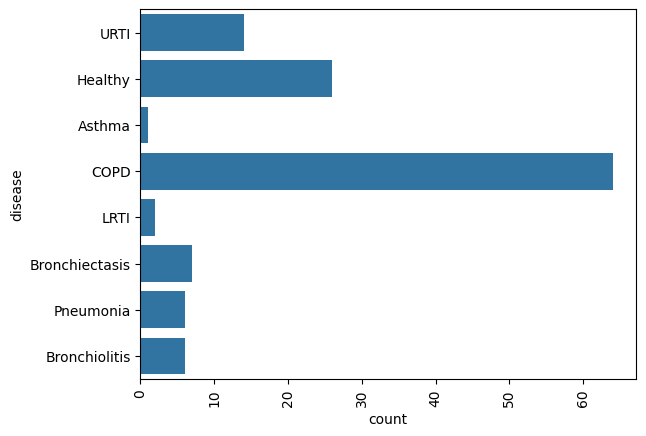

In [ ]:
sns.countplot(diagnosis_df.disease)
plt.xticks(rotation=90)

In [ ]:
path='/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
#print(files[2])
#os.listdir(path)

In [ ]:
files[:10]

['130_3p4_Pr_mc_AKGC417L',
 '186_2b3_Pr_mc_AKGC417L',
 '192_2b3_Ar_mc_LittC2SE',
 '200_2p3_Pr_mc_AKGC417L',
 '148_1b1_Al_sc_Meditron',
 '170_1b4_Pl_mc_AKGC417L',
 '149_1b1_Pl_sc_Meditron',
 '151_2p4_Tc_mc_AKGC417L',
 '205_4b2_Al_mc_AKGC417L',
 '221_2b3_Ar_mc_LittC2SE']

In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data_stretched = librosa.effects.time_stretch(data, rate=rate)
    return data_stretched


def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def show_audio(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.waveshow(y_noise, sr=sr)
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.waveshow(y_shift, sr=sr)
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.waveshow(y_stretch_1, sr=sr)
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.waveshow(y_stretch_2, sr=sr)
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.waveshow(y_pitch_shift, sr=sr)
    plt.title('pitch shift')

    plt.tight_layout()

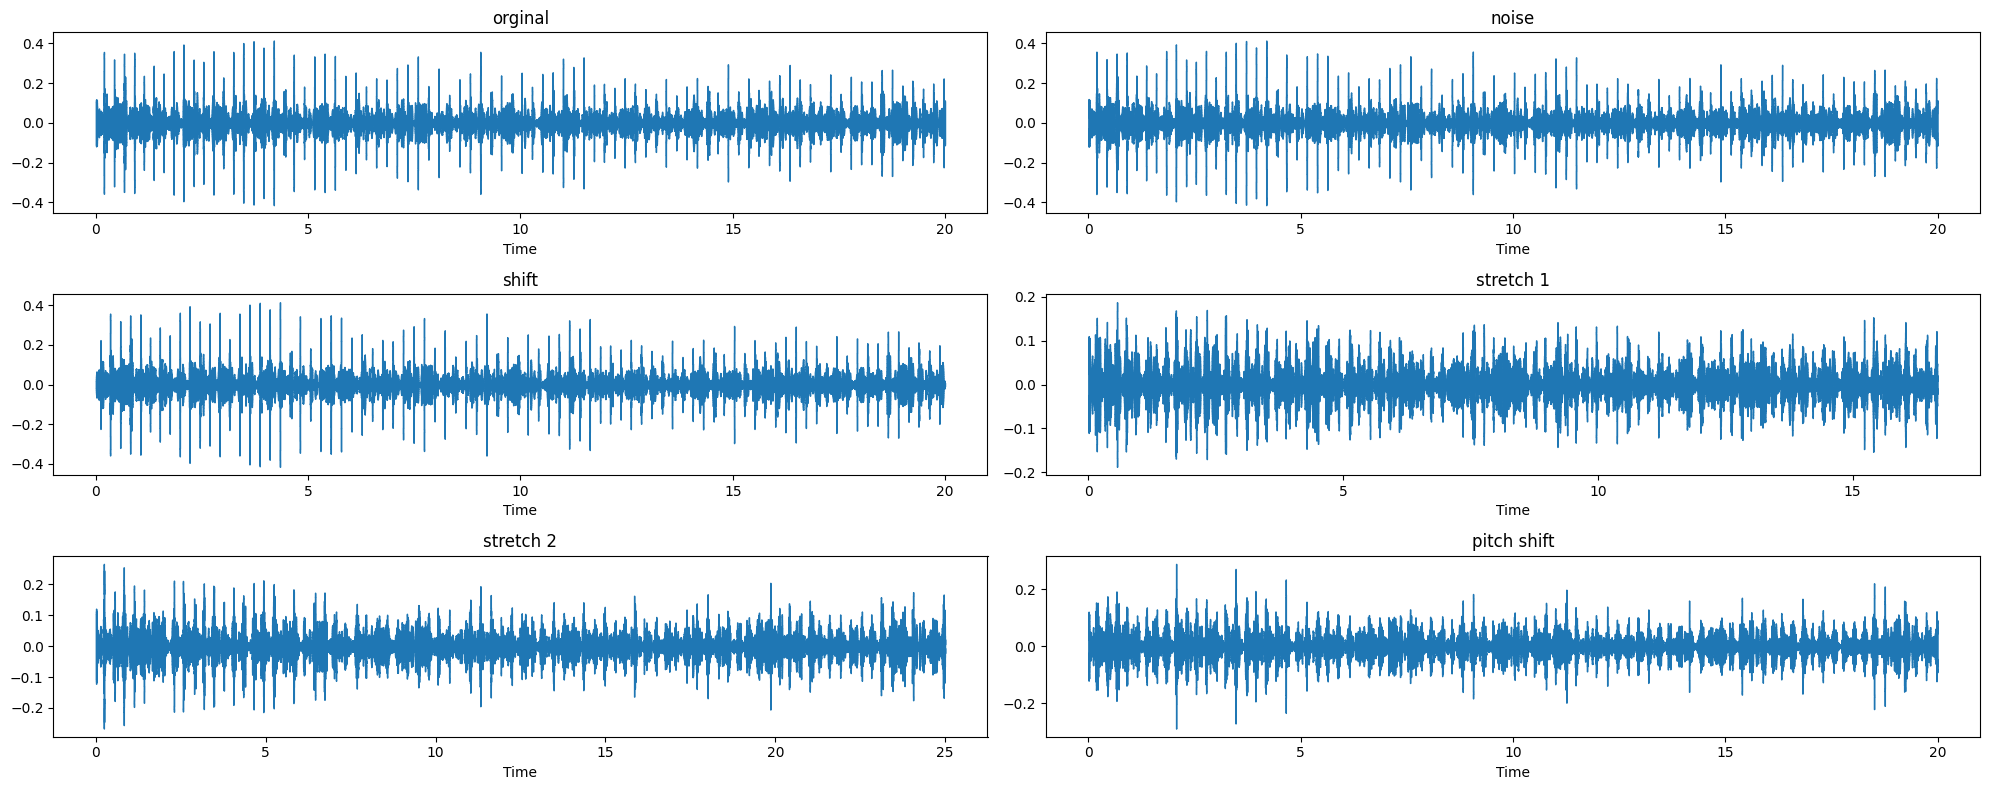

In [ ]:
show_audio('/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav')

In [ ]:
def show_audio_features(audio_path):
    y, sr = librosa.load(audio_path)
    y_noise = add_noise(y , 0.0008)
    y_shift = shift(y,3200)
    y_stretch_1 = stretch(y, 1.2)
    y_stretch_2 = stretch(y, 0.8)
    y_pitch_shift = pitch_shift(y, 3)

    y = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    y_noise = librosa.feature.mfcc(y=y_noise, sr=sr, n_mfcc=50)
    y_shift = librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=50)
    y_stretch_1 = librosa.feature.mfcc(y=y_stretch_1, sr=sr, n_mfcc=50)
    y_stretch_2 = librosa.feature.mfcc(y=y_stretch_2, sr=sr, n_mfcc=50)
    y_pitch_shift = librosa.feature.mfcc(y=y_pitch_shift, sr=sr, n_mfcc=50)

    plt.figure(figsize=(20, 8))

    plt.subplot(3,2,1)
    librosa.display.specshow(librosa.power_to_db(y,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('orginal')

    plt.subplot(3,2,2)
    librosa.display.specshow(librosa.power_to_db(y_noise,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('noise')

    plt.subplot(3,2,3)
    librosa.display.specshow(librosa.power_to_db(y_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('shift')

    plt.subplot(3,2,4)
    librosa.display.specshow(librosa.power_to_db(y_stretch_1,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 1')

    plt.subplot(3,2,5)
    librosa.display.specshow(librosa.power_to_db(y_stretch_2,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('stretch 2')

    plt.subplot(3,2,6)
    librosa.display.specshow(librosa.power_to_db(y_pitch_shift,ref=np.max),
                             y_axis='mel',
                             fmax=8000,
                             x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('pitch shift')



    plt.tight_layout()

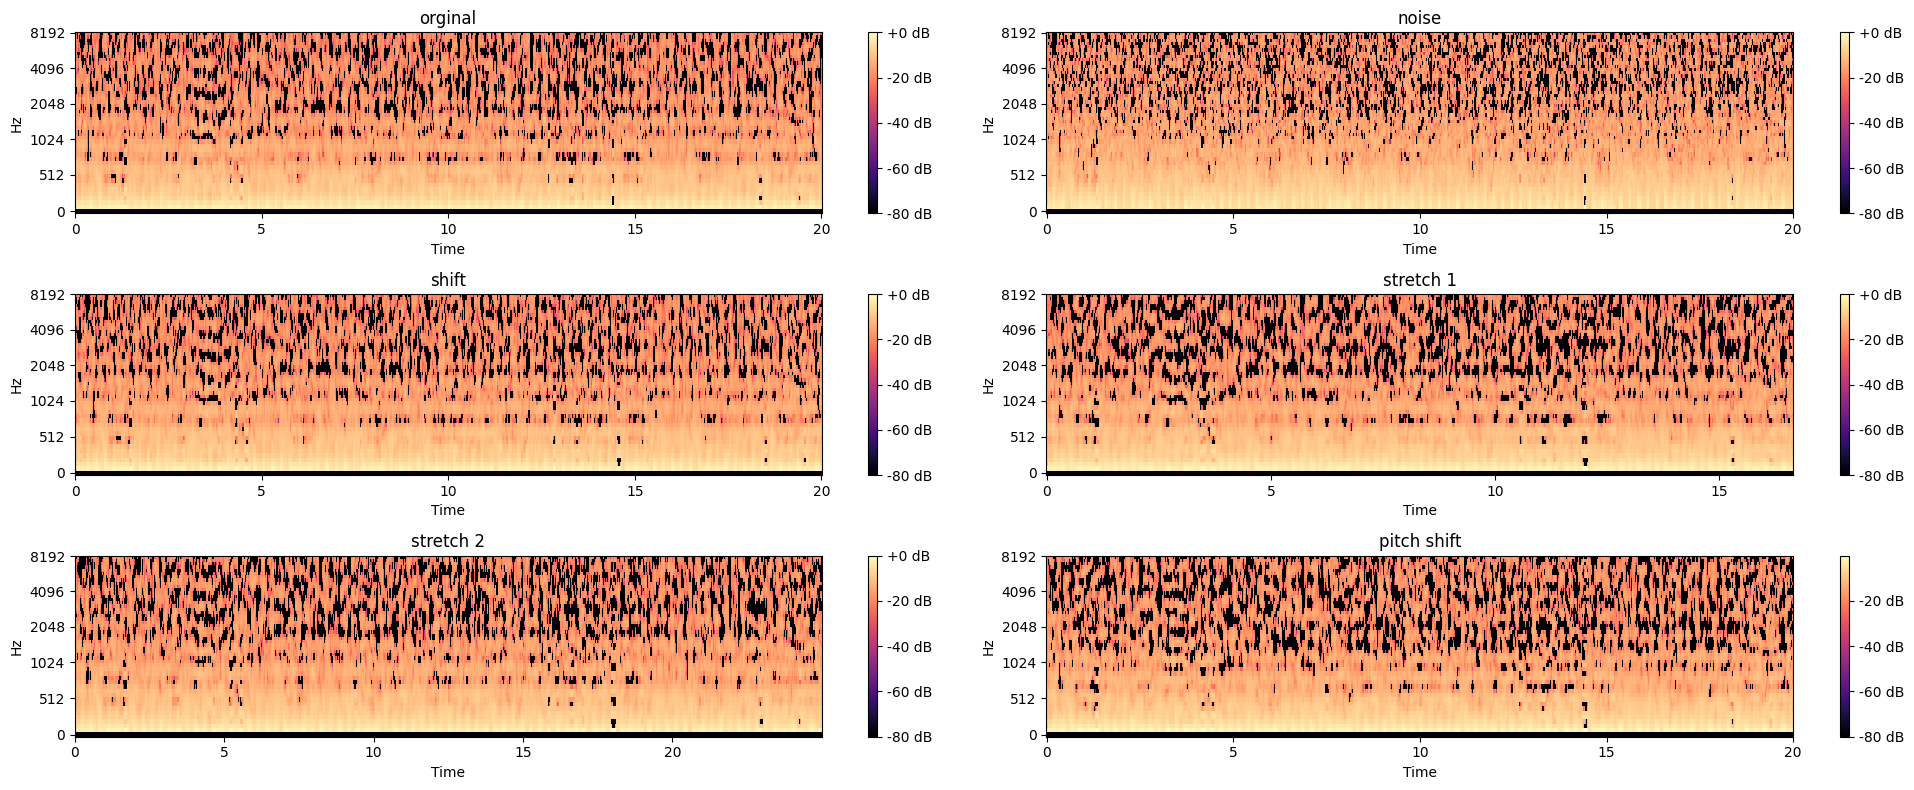

In [ ]:
show_audio_features('/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav')

In [ ]:
def mfccs_feature_exteraction(dir_):
    '''
        Extract MFCC feature from the Sound data from the audio data.
        Augmentation of sound data by adding Noise, streaching and shifting.
        50 features are extracted from each audio data and used to train the model.
        Also, we remove .wav files with patient_id 103,108, and 115 to solve data imbalance, because they have unique lables.

        Args: dir_: Input directory to the Sound input file.

        Returns:
            X_data: Array of features extracted from the sound file.
            y_data: Array of target Labels.
    '''
    X_=[]
    y_=[]

    COPD=[]
    copd_count=0

    data = diagnosis_df
    features = 52

    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav'and soundDir[:3]!='103'and soundDir[:3]!='108'and soundDir[:3]!='115':

            p = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]
            if (p=='COPD'):
                if (soundDir[:6] in COPD) and copd_count<2:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count+=1
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                if (soundDir[:6] not in COPD):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    COPD.append(soundDir[:6])
                    copd_count=0
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (p!='COPD'):
                if ((p == 'Bronchiectasis') or (p == 'Bronchiolitis')):
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append('Bronchiolitis')

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append('Bronchiolitis')

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append('Bronchiolitis')

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append('Bronchiolitis')

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append('Bronchiolitis')

                else:
                    data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs)
                    y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                    data_noise = add_noise(data_x,0.001)
                    mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_noise)
                    y_.append(p)

                    data_shift = shift(data_x,1600)
                    mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_shift)
                    y_.append(p)

                    data_stretch = stretch(data_x,1.2)
                    mfccs_stretch = np.mean(librosa.feature.mfcc(y=data_stretch, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)

                    data_stretch_2 = stretch(data_x,0.8)
                    mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=data_stretch_2, sr=sampling_rate, n_mfcc=features).T,axis=0)
                    X_.append(mfccs_stretch_2)
                    y_.append(p)

                    data_pitch_shift = pitch_shift(data_x,3)
                    mfccs_stretch = np.mean(librosa.feature.melspectrogram(y=data_pitch_shift, sr=sampling_rate, n_mels=features).T,axis=0)
                    X_.append(mfccs_stretch)
                    y_.append(p)



    X_data = np.array(X_)
    y_data = np.array(y_)


    return X_data, y_data

In [ ]:
!mkdir duplicates

mkdir: cannot create directory ‘duplicates’: File exists


In [ ]:
!unzip /content/drive/MyDrive/duplicated_audio_data.zip -d '/content/duplicates'

Archive:  /content/drive/MyDrive/duplicated_audio_data.zip
replace /content/duplicates/archive (5)/demographic_info.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Define the source and destination directories for the duplicated data
original_data_dir = '/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'
duplicated_data_dir = '/content/duplicates/duplicated_audio_data/'

# Create the duplicated data directory if it doesn't exist
os.makedirs(duplicated_data_dir, exist_ok=True)

# Duplicate the audio files from the original directory to the duplicated directory
for filename in os.listdir(original_data_dir):
    # Construct the full path for the original and duplicated files
    original_file_path = os.path.join(original_data_dir, filename)
    duplicated_file_path = os.path.join(duplicated_data_dir, filename)

    # Copy the file to the duplicated directory
    shutil.copyfile(original_file_path, duplicated_file_path)

In [ ]:
!pip uninstall librosa

Found existing installation: librosa 0.10.2.post1
Uninstalling librosa-0.10.2.post1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/librosa-0.10.2.post1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/librosa/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.10/dist-packages/librosa/__pycache__/filters.__window_ss_fill-1520.py310.1.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/__pycache__/filters.__window_ss_fill-1520.py310.nbi
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1158.py310.1.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1158.py310.2.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/audio._zc_wrapper-1158.py310.nbi
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-1158.py310.1.nbc
    /usr/local/lib/python3.10/dist-packages/librosa/core/__pycache__/guf-audio._zc_wrapper-115

In [ ]:
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
!pip install resampy

In [ ]:
x_mfccs, y = mfccs_feature_exteraction(duplicated_data_dir)

In [ ]:
def augmented_lables_count(lables):
    unique, counts = np.unique(lables, return_counts=True)
    data_count = dict(zip(unique, counts))

    data = data_count

    courses = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
            width = 0.4)

    plt.xlabel("Diseases")
    plt.ylabel("Count")
    plt.title("Count of each disease")
    plt.show()

    print (data_count)

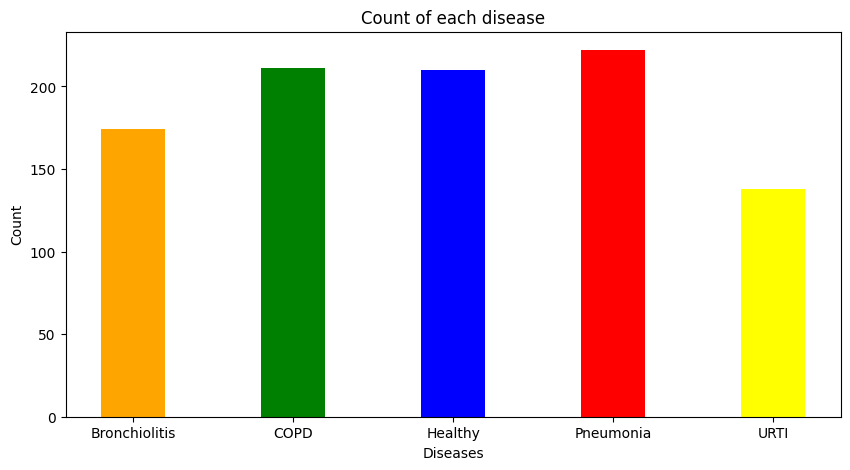

{'Bronchiolitis': 174, 'COPD': 211, 'Healthy': 210, 'Pneumonia': 222, 'URTI': 138}


In [ ]:
augmented_lables_count(y)

In [ ]:
y_data_encode = y.reshape(y.shape[0],1)
y_data_encode = np.where(y_data_encode == 'COPD',np.array([1,0,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Bronchiolitis',np.array([0,1,0,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Pneumonia',np.array([0,0,1,0,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'URTI',np.array([0,0,0,1,0]).reshape(1,5) , y_data_encode)
y_data_encode = np.where(y_data_encode == 'Healthy',np.array([0,0,0,0,1]).reshape(1,5) , y_data_encode)

Y_data = y_data_encode.astype('float64')


In [ ]:
mfccs_features = np.array(x_mfccs)
lables = np.array(Y_data)

mfccs_features.shape , lables.shape

((955, 52), (955, 5))

In [ ]:
mfcc_train, mfcc_test, lables_train, lables_test = train_test_split(mfccs_features, lables, test_size=0.1, random_state=10)
mfcc_train, mfcc_val, lables_train, lables_val = train_test_split(mfcc_train, lables_train, test_size=0.1, random_state=10)
print("Training set shape:", mfcc_train.shape, lables_train.shape)
print("Validation set shape:", mfcc_val.shape, lables_val.shape)
print("Test set shape:", mfcc_test.shape, lables_test.shape)

Training set shape: (773, 52) (773, 5)
Validation set shape: (86, 52) (86, 5)
Test set shape: (96, 52) (96, 5)


In [ ]:
x_train_gru = np.expand_dims(mfcc_train,axis=1)
x_val_gru = np.expand_dims(mfcc_val,axis=1)
x_test_gru = np.expand_dims(mfcc_test,axis=1)

y_train_gru = np.expand_dims(lables_train,axis=1)
y_val_gru = np.expand_dims(lables_val,axis=1)
y_test_gru = np.expand_dims(lables_test,axis=1)


In [ ]:
from tensorflow.keras.layers import concatenate

Input_Sample = Input(shape=(1, 52))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides=2, padding='same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_gru_1 = GRU(128, return_sequences=True, activation='tanh', go_backwards=True)(model_conv)

model_concat = concatenate([model_conv, model_gru_1])

model_dense_1 = Dense(128, activation='relu')(model_concat)
model_output = Dense(5, activation='softmax')(model_dense_1)

gru_model = Model(inputs=Input_Sample, outputs=model_output)

gru_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1, 52)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 1, 256)         │         66,816 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 1, 256)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1, 256)         │          1,024 │ max_pooling1d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 1, 128)         │        148,224 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1, 384)         │              0 │ batch_normalization[0… │
│                           │                        │                │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 128)         │         49,280 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 5)           │            645 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 265,989 (1.01 MB)

 Trainable params: 265,477 (1.01 MB)

 Non-trainable params: 512 (2.00 KB)

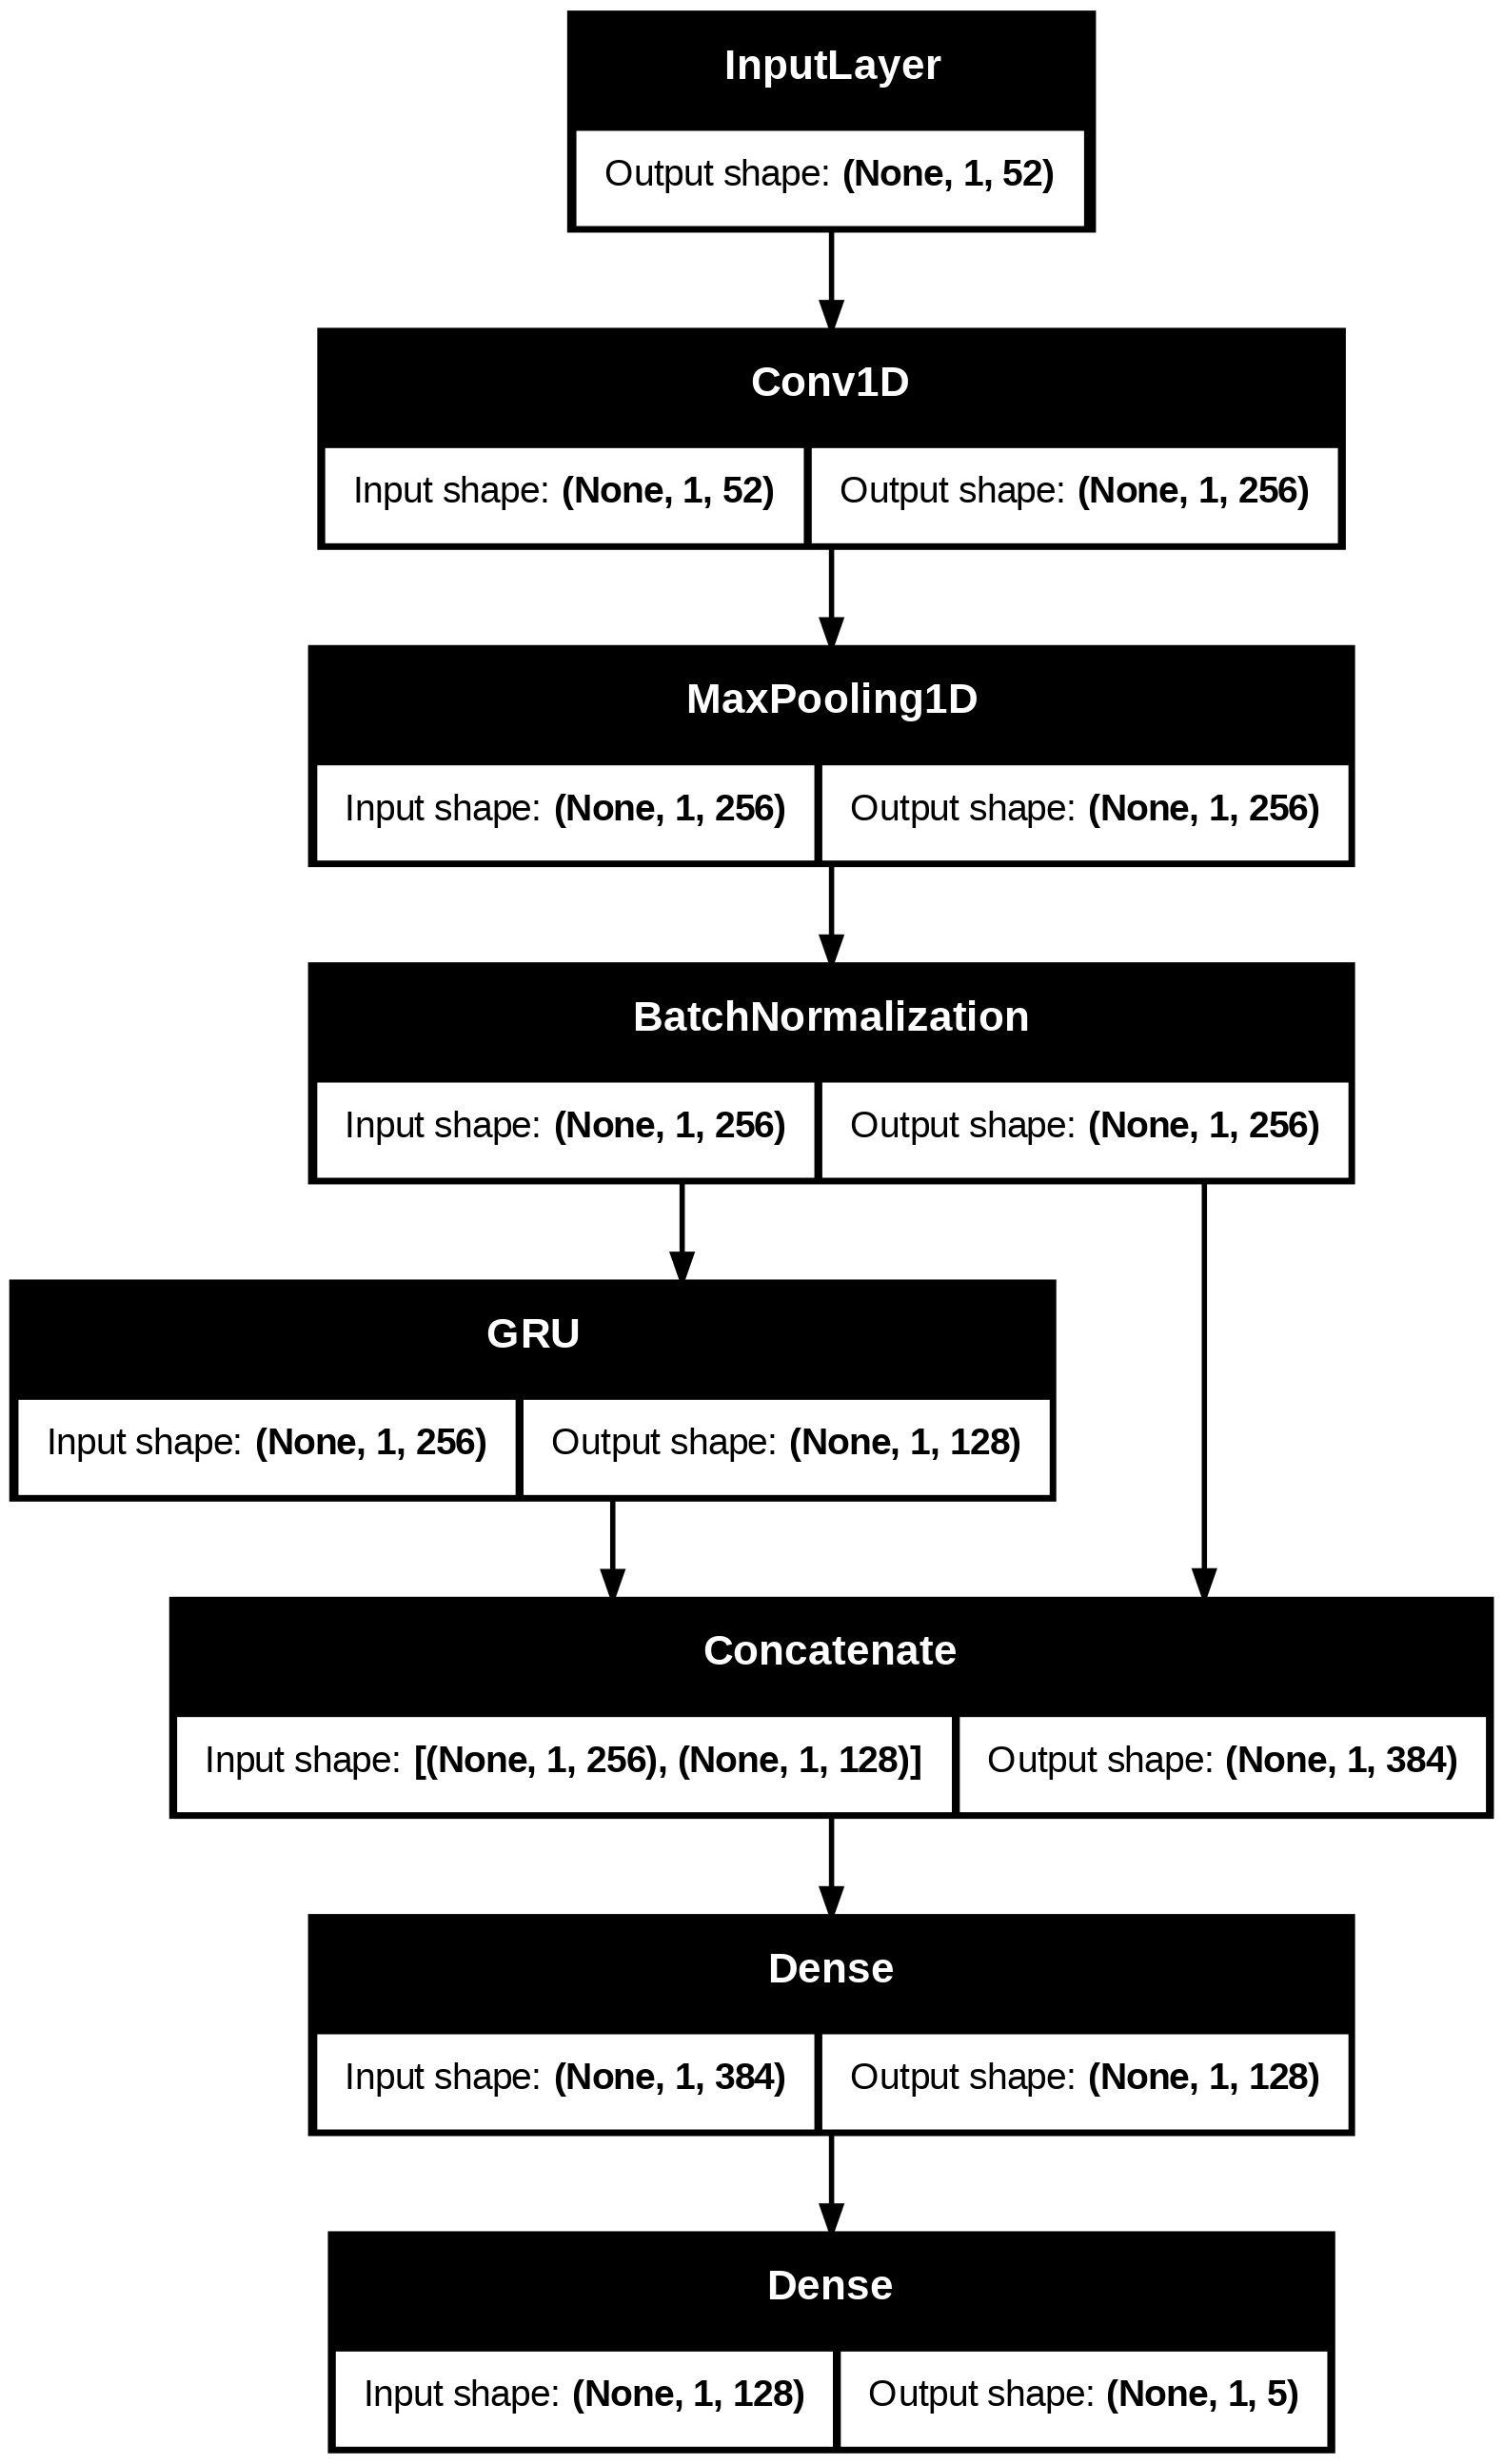

In [ ]:
tf.keras.utils.plot_model(gru_model, "gru_model.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0002)
gru_model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['accuracy'])

cb = [EarlyStopping(patience=300,monitor='accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("/content/drive/MyDrive/ress/GRU_CNN_1.keras",save_best_only=True)]

In [ ]:
history = gru_model.fit(x_train_gru, y_train_gru, batch_size=8, epochs=150, validation_data=(x_val_gru, y_val_gru), callbacks = cb)

Epoch 1/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.3621 - loss: 1.4901 - val_accuracy: 0.5000 - val_loss: 1.1936
Epoch 2/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5432 - loss: 1.1911 - val_accuracy: 0.5814 - val_loss: 1.1051
Epoch 3/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5808 - loss: 1.0919 - val_accuracy: 0.4884 - val_loss: 1.0846
Epoch 4/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5820 - loss: 1.0560 - val_accuracy: 0.6744 - val_loss: 0.9165
Epoch 5/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6149 - loss: 0.9957 - val_accuracy: 0.6279 - val_loss: 0.8754
Epoch 6/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6811 - loss: 0.8738 - val_accuracy: 0.6395 - val_loss: 0.8724
Epoch 7/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6653 - loss: 0.8495 - val_accuracy: 0.6977 - val_loss: 0.7889
Epoch 8/150
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7142 - loss: 0.7714 - val_accuracy: 0.6279 - 

In [ ]:
model_name = 'lung_sounds_new_org.h5'
gru_model.save(model_name, save_format='h5')

In [ ]:
Model_Results = gru_model.evaluate(x_train_gru, y_train_gru)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9062 - loss: 0.2646
LOSS:  0.3035
ACCURACY:  0.8823


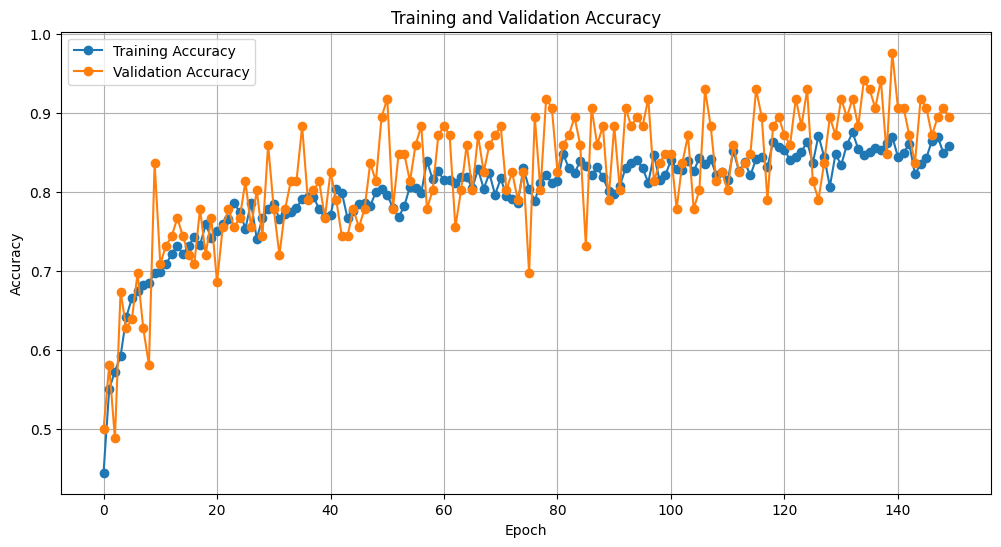

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


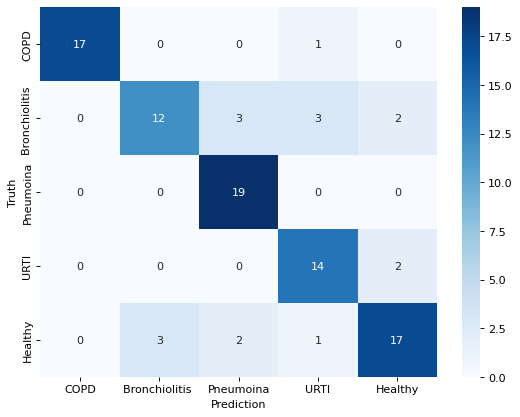

In [ ]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]
preds = gru_model.predict(x_test_gru)
classpreds = [np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

                precision    recall  f1-score   support

          COPD       1.00      0.94      0.97        18
Bronchiolitis        0.80      0.60      0.69        20
     Pneumoina       0.79      1.00      0.88        19
          URTI       0.74      0.88      0.80        16
       Healthy       0.81      0.74      0.77        23

      accuracy                           0.82        96
     macro avg       0.83      0.83      0.82        96
  weighted avg       0.83      0.82      0.82        96



In [ ]:
!cp '/content/lung_sounds_new_org.h5' '/content'

cp: '/content/lung_sounds_new_org.h5' and '/content/lung_sounds_new_org.h5' are the same file


In [ ]:
gru_model= load_model("/content/lung_sounds_new_org.h5")

In [ ]:
classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

In [ ]:
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

In [ ]:
def predict_class(audio_file_path, gru_model, classes, features=52, soundDir=''):
    val = []
    data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
    val.append(mfccs)
    val = np.expand_dims(val, axis=1)
    prediction = classes[np.argmax(gru_model.predict(val))]
    print(prediction)
    print('*************')


In [ ]:
dir1 = '/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav'
predict_class(dir1, gru_model, classes)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
URTI
*************


In [ ]:
dir2 = '/content/soundss/archive (5)/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav'
predict_class(dir2, gru_model, classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Healthy
*************


In [ ]:
dir2 = '/content/pneumonia4.wav'
predict_class(dir2, gru_model, classes)

In [ ]:
dir1 = '/content/uriti3.wav'
predict_class(dir1, gru_model, classes)


In [ ]:
dir1 = '/content/bronchiolitis.wav'
predict_class(dir1, gru_model, classes)


In [ ]:
dir1 = '/content/bronchiolitis2.wav'
predict_class(dir1, gru_model, classes)


In [ ]:
dir1 = '/content/bronchiolitis1.wav'
predict_class(dir1, gru_model, classes)


In [ ]:
dir1 = '/content/Bronchiolitis3.wav'
predict_class(dir1, gru_model, classes)


In [ ]:
import librosa
import resampy
import numpy as np
from tensorflow.keras.models import load_model


classes = ["COPD" ,"Bronchiolitis ", "Pneumoina", "URTI", "Healthy"]

gru_model= load_model("/content/lung_sounds_new_org.h5")
def gru_diagnosis_prediction(test_audio):
    data_x, sampling_rate = librosa.load(test_audio)
    data_x = stretch (data_x,1.2)

    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=52).T,axis = 0)

    features = features.reshape(1,52)

    test_pred = gru_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds , confidence)

def predict_class(audio_file_path, gru_model, classes, features=52, soundDir=''):
    val = []
    data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T, axis=0)
    val.append(mfccs)
    val = np.expand_dims(val, axis=1)
    prediction = classes[np.argmax(gru_model.predict(val))]
    print(prediction)
    print('*************')
dir1 = '/content/Healthy2.wav'
predict_class(dir1, gru_model, classes)



<ipython-input-62-19e2ebf10d3e>:26: UserWarning: PySoundFile failed. Trying audioread instead.
  data_x, sampling_rate = librosa.load(audio_file_path + soundDir, res_type='kaiser_fast')
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Healthy2.wav'